# Stacking

Предлагаем вам на примере решения модельной задачи самим убедиться в верности утверждения, что стекинг не всегда существенно повышает качество лучшего из базовых алгоритмов, но если этот алгоритм убрать из базовых, то и качество стекинга не сильно упадет.

Запустите следующие 4 ячейки.

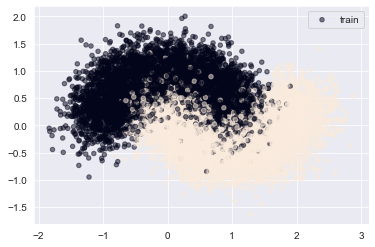

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


x, y = make_moons(15000, noise=0.3, random_state=17)

train, test, train_true, test_true = train_test_split(x, 
                                                      y,
                                                      train_size=0.7,
                                                      random_state=17)

x_train, valid, y_train, valid_true = train_test_split(train, 
                                                      train_true, 
                                                      train_size=0.6, 
                                                      random_state=17)

plt.scatter(train[:, 0], train[:, 1], c=train_true, s=20, alpha=0.5, label='train')
plt.legend()

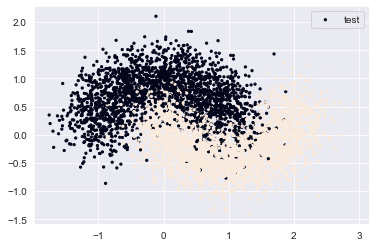

In [2]:
plt.scatter(test[:, 0], test[:, 1], c=test_true, s=5, alpha=1.0, label='test')
plt.legend()

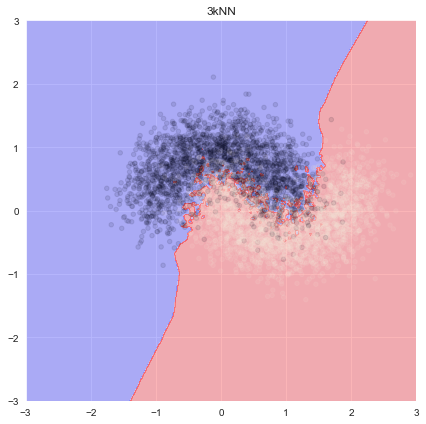

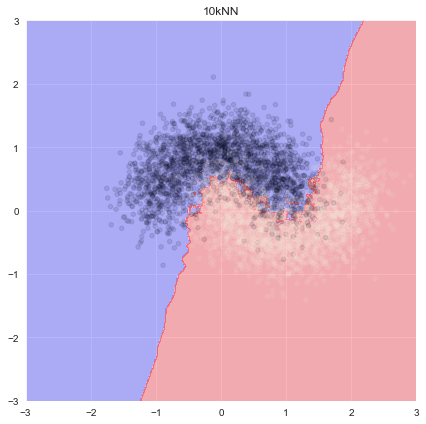

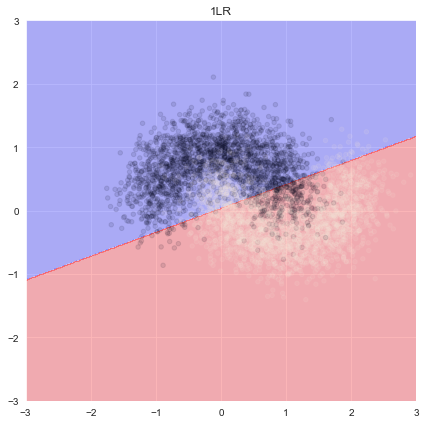

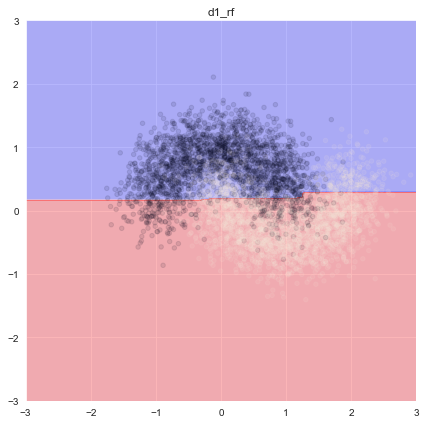

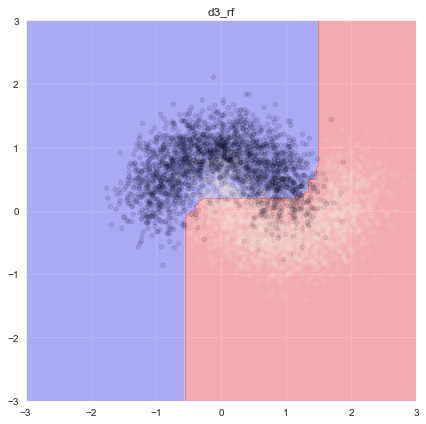

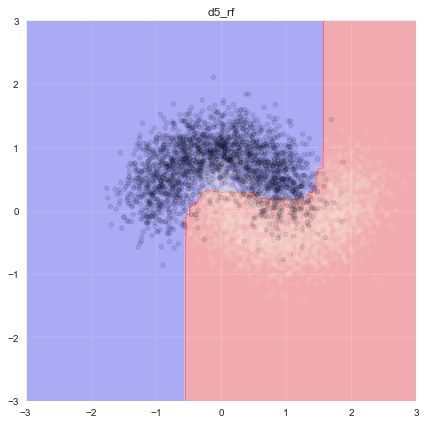

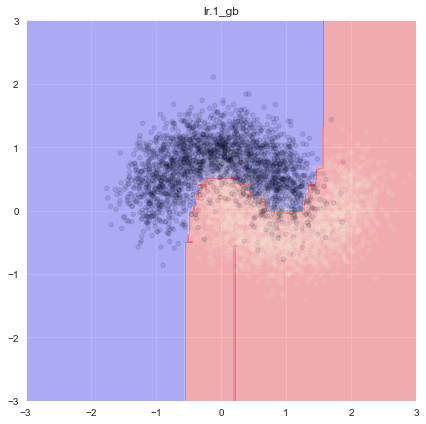

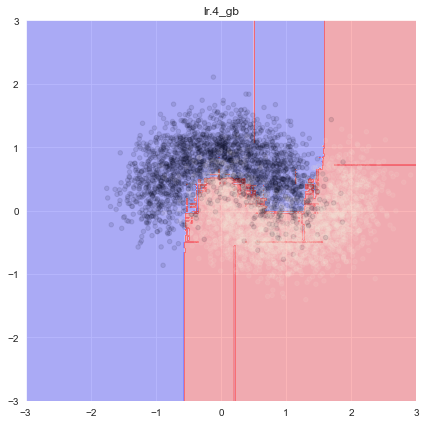

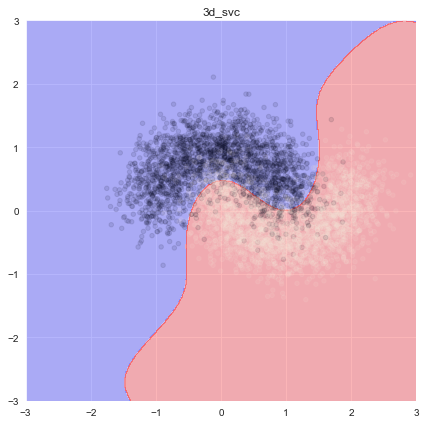

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def plot(alg, data, targets, label):
    xx, yy = np.meshgrid(np.linspace(-3., 3., 500), np.linspace(-3., 3., 500))
    Z = alg.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(7, 7))
    plt.contourf(xx, yy, Z, levels=10, cmap=plt.cm.bwr, alpha=0.3)
    
    plt.scatter(data[:, 0], data[:, 1], s=20, c=targets, alpha=0.1)
    
    plt.xlim((-3, 3))
    plt.ylim((-3, 3))
    plt.title(label)
    

knn1 = KNeighborsClassifier(n_neighbors=3)
knn1.fit(x_train, y_train)
plot(knn1, test, test_true, '3kNN')

knn2 = KNeighborsClassifier(n_neighbors=10)
knn2.fit(x_train, y_train)
plot(knn2, test, test_true, '10kNN')

lr = LogisticRegression(C=10, random_state=17)
lr.fit(x_train, y_train)
plot(lr, test, test_true, '1LR')

rf1 = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=17)
rf1.fit(x_train, y_train)
plot(rf1, test, test_true, 'd1_rf')

rf2 = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=17)
rf2.fit(x_train, y_train)
plot(rf2, test, test_true, 'd3_rf')

rf3 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=17)
rf3.fit(x_train, y_train)
plot(rf3, test, test_true, 'd5_rf')

gb1 = GradientBoostingClassifier(learning_rate=0.1, random_state=17)
gb1.fit(x_train, y_train)
plot(gb1, test, test_true, 'lr.1_gb')

gb2 = GradientBoostingClassifier(learning_rate=0.4, random_state=17)
gb2.fit(x_train, y_train)
plot(gb2, test, test_true, 'lr.4_gb')

svc = SVC(degree=3, random_state=17)
svc.fit(x_train, y_train)
plot(svc, test, test_true, '3d_svc')

0 auc: 0.8971313863234087
1 auc: 0.9139757690299333
2 auc: 0.8522046357837013
3 auc: 0.8215518046981363
4 auc: 0.8926628837592676
5 auc: 0.9040736424237767
6 auc: 0.9173543856917827
7 auc: 0.9066244476235391
8 auc: 0.9159963007298768
Stacking AUC: 0.9155027749465133


Text(0, 0.5, 'AUC')

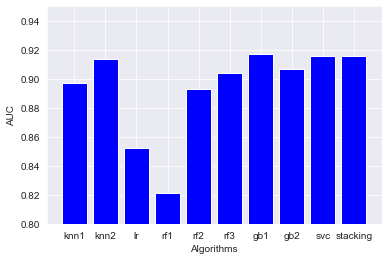

In [32]:
models = [knn1, knn2, lr, rf1, rf2, rf3, gb1, gb2, svc]
meta_mtrx = np.empty((valid.shape[0], len(models))) # (кол-во объектов, 9 алгоритмов)

for n, model in enumerate(models):
    meta_mtrx[:, n] = model.predict(valid)
    predicted = model.predict(test)
    print(f'{n} auc: {roc_auc_score(test_true, predicted)}')
    
meta = GradientBoostingClassifier(n_estimators=60, random_state=17)
meta_model = meta.fit(meta_mtrx, valid_true)

meta_mtrx_test = np.empty((test.shape[0], len(models))) 

for n, model in enumerate(models):
    meta_mtrx_test[:, n] = model.predict(test)
    
meta_predict = meta.predict(meta_mtrx_test)
print(f'Stacking AUC: {roc_auc_score(test_true, meta_predict)}')


# построим графики, где по оси  y  значения AUC для всех классификаторов, а по оси  x  - сами алгоритмы.

alg = ['knn1', 'knn2', 'lr', 'rf1', 'rf2', 'rf3', 'gb1', 'gb2', 'svc', 'stacking'] # названия алгоритмов
auc = [] # значения auc для alg
for model in models:
    predicted = model.predict(test)
    auc.append(roc_auc_score(test_true, predicted))
auc.append(roc_auc_score(test_true, meta_predict))
    
plt.bar(np.arange(len(auc)), auc, color='blue', label='алгоритмы')
plt.xticks(np.arange(len(auc)), alg)
plt.ylim([0.8, 0.95])
plt.xlabel('Algorithms')
plt.ylabel('AUC')

Теперь предлагаем вам самостоятельно построить мета-модель без метапризнаков двух лучших алгоритмов (gb1 и svc1) и посмотреть на подобном графике, насколько сильно отличаются значения AUC мета-алгоритмов.

In [33]:
models = [knn1, knn2, lr, rf1, rf2, rf3, gb2]
meta_mtrx = np.empty((valid.shape[0], len(models)))

for n, model in enumerate(models):
    # сделайте предсказания для валидационных данных
    # ваш код
    meta_mtrx[:, n] = model.predict(valid)
    predicted = model.predict(test)
    print(f'{n} auc: {roc_auc_score(test_true, predicted)}')
    
meta = GradientBoostingClassifier(n_estimators=5, random_state=17)
# обучите мета-модель на валидационных данных
# ваш код

meta_model = meta.fit(meta_mtrx, valid_true)
meta_mtrx_test = np.empty((test.shape[0], len(models))) 

for n, model in enumerate(models):
    # ваш код
    meta_mtrx_test[:, n] = model.predict(test)
    
# сделайте предсказания для мета-алгоритма
# ваш код
meta_predict = meta.predict(meta_mtrx_test)
print(f'Stacking AUC: {roc_auc_score(test_true, meta_predict)}')

alg2 = ['knn1', 'knn2', 'lr', 'rf1', 'rf2', 'rf3', 'gb2', 'stacking'] # названия алгоритмов
auc2 = [] # значения auc для alg
for model in models:
    predicted = model.predict(test)
    auc2.append(roc_auc_score(test_true, predicted))
auc2.append(roc_auc_score(test_true, meta_predict))

# выведите график для всех обученных моделей (включая gb1 и svc) и stacking'а, обученного на них
# выведите здесь же график для нового значения auc stacking'а, укажите color='red'

0 auc: 0.8971313863234087
1 auc: 0.9139757690299333
2 auc: 0.8522046357837013
3 auc: 0.8215518046981363
4 auc: 0.8926628837592676
5 auc: 0.9040736424237767
6 auc: 0.9066244476235391
Stacking AUC: 0.9176225847513966


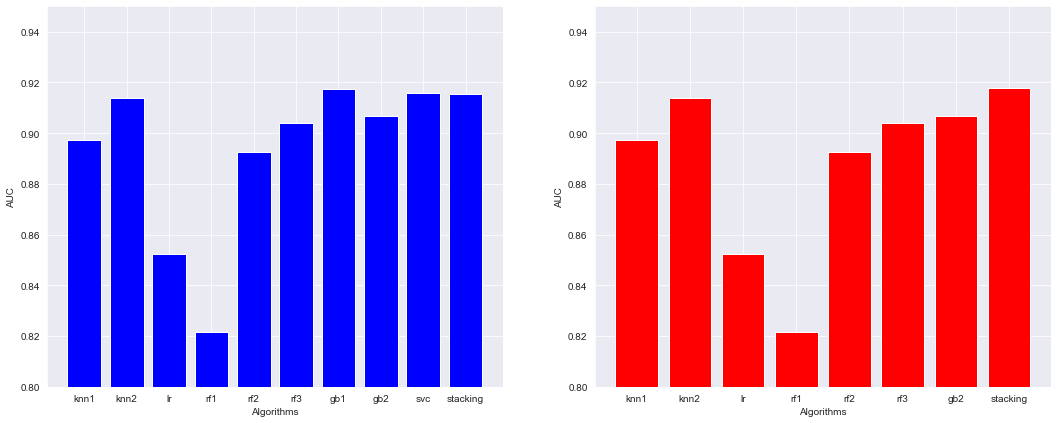

In [38]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 7))

axs[0].bar(np.arange(len(auc)), auc, color='blue', label='алгоритмы')
axs[0].set_xticks(range(len(alg)))
axs[0].set_xticklabels(alg)
axs[0].set_ylim([0.8, 0.95])
axs[0].set_xlabel('Algorithms')
axs[0].set_ylabel('AUC')

axs[1].bar(np.arange(len(auc2)), auc2, color='red')
axs[1].set_xticks(range(len(alg2)))
axs[1].set_xticklabels(alg2)
axs[1].set_ylim([0.8, 0.95])
axs[1].set_xlabel('Algorithms')
axs[1].set_ylabel('AUC')

plt.show()